In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

/home/alexattia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('./train.csv')

In [43]:
df_test = pd.read_csv('./test.csv')

In [3]:
target = pd.read_csv('./challenge_output_data_training_file_nba_challenge.csv', sep=';')

**Data**   
Play-by-play datasets from the last 15 NBA seasons.  
Each game is described by 11 variables for every second of the game from the fist halft (1440 seconds, **1440x11 = 15840 columns**). These variables such as : "offensive rebound", "defensive rebound", "offensive foul", "defensive foul", "assist", "lost ball",  "steals", "bad pass","block", "miss" difference between the invited and home team. The scores/key indicators - represent the current score/key indicators differences.

The training set : 12576 NBA games.  
The test set : 4192 games.

In [4]:
print(df.shape)
print(target.shape)
df.head()

(12576, 15841)
(12576, 2)


,ID,score_1,offensive rebound_1,defensive rebound_1,offensive foul_1,defensive foul_1,assist_1,lost ball_1,steals_1,bad pass_1,...,offensive rebound_1440,defensive rebound_1440,offensive foul_1440,defensive foul_1440,assist_1440,lost ball_1440,steals_1440,bad pass_1440,block_1440,miss_1440
0,14186,-2,0,0,0,0,0,0,0,0,...,8,-4,2,0,-3,3,3,-2,1,9
1,13013,0,0,-1,0,0,0,0,0,0,...,1,5,0,0,1,0,0,1,-2,-1
2,7102,0,0,0,0,0,0,0,1,1,...,-1,-5,-5,0,0,5,5,-2,3,-5
3,7637,-2,0,0,0,0,0,0,0,0,...,2,8,1,0,-1,-1,2,2,-1,-1
4,12350,0,0,0,0,0,0,0,0,0,...,4,1,0,0,4,3,2,1,1,3


In [4]:
df_tot = pd.merge(df, target, on='ID')
# When the HT winner is the FT winner
same_mt_f = df_tot[((df_tot.score_1440 <= 0) & (df_tot.label == 0)) | ((df_tot.score_1440 >= 0) & (df_tot.label == 1))]
print('Probability that the half-time leader is the full-time winner %.3f' % (len(same_mt_f)/len(df_tot)))

Probability that the half-time leader is the full-time winner 0.743


In [7]:
print('Probability that the home team wins the game at FT %.3f' % (len(df_tot[df_tot.label == 0])/len(df_tot)))
print('Probability that the home team wins the game at HT %.3f' % (len(df_tot[df_tot.score_1440 <= 0])/len(df_tot)))

Probability that the home team wins the game at FT 0.564
Probability that the home team wins the game at HT 0.589


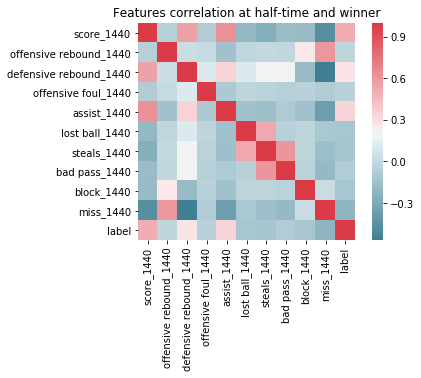

In [6]:
corr_ht = df_tot[[k for k in df_tot.columns if '1440' in k and 'defensive foul' not in k]+['label']].corr()
sns.heatmap(corr_ht, mask=np.zeros_like(corr_ht, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True)
_ = plt.title('Features correlation at half-time and winner')

In [5]:
# Add new stats
ki = set([k.split('_')[0] for k in df_tot.columns if k not in ['label', 'ID']])
print('Current key indicators :', ki)

# Add total rebound
for k in range(1,1441):
    df_tot['total rebound_%d' % k] = df_tot['offensive rebound_%d' % k] + df_tot['defensive rebound_%d' % k]

# Re-sort columns
def sorter(x):
    if x not in ['label', 'ID']:
        return int(x.split('_')[1])
    else:
        return 0
    
df_tot = df_tot[sorted(df_tot.columns, key=sorter)]
print('Added total (off+def) rebound stats')

Current key indicators : {'assist', 'offensive rebound', 'defensive rebound', 'block', 'defensive foul', 'miss', 'steals', 'offensive foul', 'score', 'lost ball', 'bad pass'}
Added total (off+def) rebound stats


In [44]:
# Add new stats
ki = set([k.split('_')[0] for k in df_test.columns if k not in ['label', 'ID']])
print('Current key indicators :', ki)

# Add total rebound
for k in range(1,1441):
    df_test['total rebound_%d' % k] = df_test['offensive rebound_%d' % k] + df_test['defensive rebound_%d' % k]

# Re-sort columns
def sorter(x):
    if x not in ['label', 'ID']:
        return int(x.split('_')[1])
    else:
        return 0
    
df_test = df_test[sorted(df_test.columns, key=sorter)]
print('Added total (off+def) rebound stats')

Current key indicators : {'assist', 'offensive rebound', 'defensive rebound', 'block', 'defensive foul', 'miss', 'steals', 'offensive foul', 'score', 'lost ball', 'bad pass'}
Added total (off+def) rebound stats


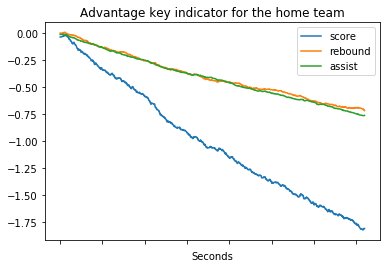

In [10]:
f, ax = plt.subplots()
df_tot[[k for k in df_tot.columns if 'score' in k]].mean().plot(ax=ax, label='score')
df_tot[[k for k in df_tot.columns if 'total rebound' in k]].mean().plot(ax=ax, label='rebound')
df_tot[[k for k in df_tot.columns if 'assist' in k]].mean().plot(ax=ax, label='assist')
ax.set_title('Advantage key indicator for the home team')
ax.set_xlabel('Seconds')
_ = ax.legend()

https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb  
Keras LSTM layers expect an input in the shape of a numpy array of 3 dimensions (samples, time steps, features) where samples is the number of training sequences, time steps is the look back window or sequence length and features is the number of features of each sequence at each time step.

In [6]:
df_tot.shape

(12576, 17282)

In [6]:
# Reformat with only 10 games
# For the reformating with reshape the dataframe
# from (10, 17282) to (10*1440, n_features)
df1 = df_tot#.sample(1000)

In [7]:
df1_tot = pd.DataFrame()
for sec in range(1,1441):
    df_sec = df1[['ID', 'label']+[k for k in df1.columns if k not in ['label', 'ID'] and k.split('_')[1] == str(sec)]]
    df_sec.columns = [k.split('_')[0] if k not in ['ID', 'time_step', 'label'] else k for k in df_sec.columns]
    df_sec = df_sec.assign(time_step = sec)
    df1_tot = pd.concat([df1_tot, df_sec])
df1_tot = df1_tot.sort_values(['ID', 'time_step'])

In [46]:
df_test_tot = pd.DataFrame()
for sec in range(1,1441):
    df_sec = df_test[['ID']+[k for k in df_test.columns if k not in ['ID'] and k.split('_')[1] == str(sec)]]
    df_sec.columns = [k.split('_')[0] if k not in ['ID', 'time_step'] else k for k in df_sec.columns]
    df_sec = df_sec.assign(time_step = sec)
    df_test_tot = pd.concat([df_test_tot, df_sec])
df_test_tot = df_test_tot.sort_values(['ID', 'time_step'])

In [8]:
df1_tot.head()

,ID,label,score,offensive rebound,defensive rebound,offensive foul,defensive foul,assist,lost ball,steals,bad pass,block,miss,total rebound,time_step
2677,1,1,0,0,0,0,0,0,0,0,0,0,-1,0,1
2677,1,1,0,0,0,0,0,0,0,0,0,0,-1,0,2
2677,1,1,0,0,0,0,0,0,0,0,0,0,-1,0,3
2677,1,1,0,0,0,0,0,0,0,0,0,0,-1,0,4
2677,1,1,0,0,0,0,0,0,0,0,0,0,-1,0,5


In [9]:
print('Initial Shape', df1.shape)
print('Final Shape', df1_tot.shape)

Initial Shape (12576, 17282)
Final Shape (18109440, 15)


In [10]:
from mcfly import modelgen, find_architecture, storage
from keras.models import load_model

In [11]:
cols = ['score', 'offensive rebound', 'defensive rebound',
       'offensive foul', 'defensive foul', 'assist', 'lost ball', 'steals',
       'bad pass', 'block', 'miss', 'total rebound']

In [14]:
df_X = df1_tot[df1_tot.time_step < 1441]
X_train = []
y_train = df_X.groupby('ID').mean()['label'].values
y_train = y_train.reshape((len(y_train), 1))
for id_ in df1_tot.ID.unique():
    X_train.append(df_X[df_X.ID == id_][cols].values)
X_train = np.array(X_train)
X_train.shape, y_train.shape

((12576, 1440, 12), (12576, 1))

In [47]:
df_X_test = df_test_tot[df_test_tot.time_step < 1441]
X_test = []
for id_ in df_X_test.ID.unique():
    X_test.append(df_X_test[df_X_test.ID == id_][cols].values)
X_test = np.array(X_test)
X_test.shape

(4192, 1440, 12)

In [15]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)

In [16]:
from keras.layers import BatchNormalization, Conv2D, Reshape, LSTM, Dropout, Dense, TimeDistributed
from keras.optimizers import Adam
from keras.regularizers import l2

nb_timestep = 1440
nb_features = 12

my_model = Sequential()

my_model.add(BatchNormalization(input_shape = (nb_timestep,nb_features)))
my_model.add(Reshape([nb_timestep,nb_features,1]))
my_model.add(Conv2D(61, 1,activation="relu"))
my_model.add(BatchNormalization())
my_model.add(Conv2D(36,1,activation="relu"))
my_model.add(BatchNormalization())
my_model.add(Reshape([nb_timestep,nb_features*36]))
my_model.add(LSTM(49, return_sequences=True))
my_model.add(LSTM(35,return_sequences=True))
my_model.add(LSTM(71,return_sequences=True))
my_model.add(LSTM(19,return_sequences=True))
my_model.add(LSTM(65,return_sequences=True))
my_model.add(Dropout(0.2))
my_model.add(TimeDistributed(Dense(2,activation="sigmoid", kernel_regularizer=l2(0.0001))))
my_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

In [ ]:
my_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.15, verbose=1)

In [48]:
y_pred = my_model.predict(X_test, batch_size=32)

In [ ]:
y_ = my_model.predict(X_train, batch_size=32)

In [ ]:
from public_accuracy import score_function
score_function(np.argmax(y_, axis=1), np.argmax(y_train, axis=1))

In [71]:
Pred = pd.DataFrame(np.argmax(y_pred, axis=1), columns= ['label'])
Pred['ID'] = df_X_test.groupby('ID').ID.first().values
Pred[['ID', 'label']].to_csv('pred_v1.csv', index=False)